In [1]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
import pandas as pd
import helper as h
figsize=(10, 5)
# %matplotlib notebook

# Calibrating Cameras with the Raspberry Pi

The [Raspberry Pi](https://www.raspberrypi.org) offers a new high [quality sensor](https://www.raspberrypi.org/products/raspberry-pi-high-quality-camera/) that uses c-cs mounted lenses. The ones tested here are the 6mm wide-angle lens and the telephoto lens developed by the raspberry pi folks. 
*Notes*:
- Every third frame is in focus


## Reading in the Data

After taping a checkerboard to the wall, I took pictures of the paper from approximately 2' away. We can use the multiple images taken to calibrate the camera. Let's first read in the $n$ images.

In [2]:
n = 16
directory = "WideAngle"
calibration_images = []
for index in range(1,n+1):
    calibration_images.append(
        cv2.imread(os.path.join(directory, f"CALIBRATION{index:03}.png"))
    )

So now we've got the $n$ images in memory. Let's look at the gray-scale histogram of the different images.

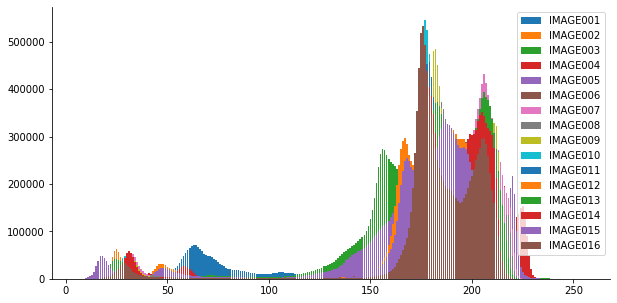

In [3]:
gray_df = pd.DataFrame()
fig, ax = plt.subplots(figsize=figsize)
for index in range(n):
    gray_df[f"IMAGE{index+1:03}"] = cv2.cvtColor(calibration_images[index], cv2.COLOR_BGR2GRAY).flatten()
    ax.bar(
        gray_df[f"IMAGE{index+1:03}"].value_counts().sort_index().index, 
        gray_df[f"IMAGE{index+1:03}"].value_counts().sort_index().values,
        label=f"IMAGE{index+1:03}"
    )
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.legend()
plt.show()

Here, we see that the images have two local maxima of gray scale values. We are interested in the *darker colored* pixels in the checkerboard. So let's look at the left-most local maxima.

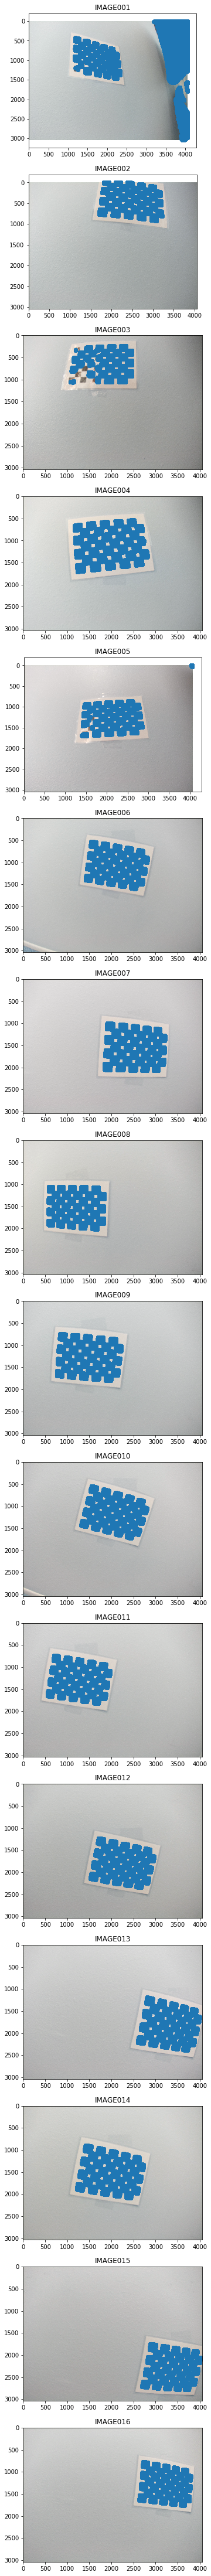

In [4]:
fig, axes = plt.subplots(n, 1, figsize=(figsize[0], figsize[1]*n))
darkpixel_dict = {
    f"IMAGE{index+1:03}":[
        (point%calibration_images[0].shape[1], int(point/calibration_images[0].shape[1]))
        for point in gray_df.loc[
            (gray_df[f"IMAGE{index+1:03}"]>25) & (gray_df[f"IMAGE{index+1:03}"]<75), 
            f"IMAGE{index+1:03}"
        ].index
    ]
    for index in range(n)
}
for index in range(n):
    axes[index].imshow(calibration_images[index])
    axes[index].scatter(
        [x[0] for x in darkpixel_dict[f"IMAGE{index+1:03}"]], 
        [x[1] for x in darkpixel_dict[f"IMAGE{index+1:03}"]]
    )
    axes[index].set_title(f"IMAGE{index+1:03}")

Looks like we found the checkerboard! There are a few errors in our process though. First, the chair in the first image is considered a part of the checkerboard. Second, the laminated checkerboard is reflective which results in the checkerboard having a different color value.

We can remove these false positives by segmenting the checkerboard pixels from the false positives. In my opinion, the best way to do this would be look for a uniform distribution in both the $x$ and $y$ directions. If one is not uniform, remove the outliers until it is uniform. Let's first look at the distribution of the $x$-coordinates

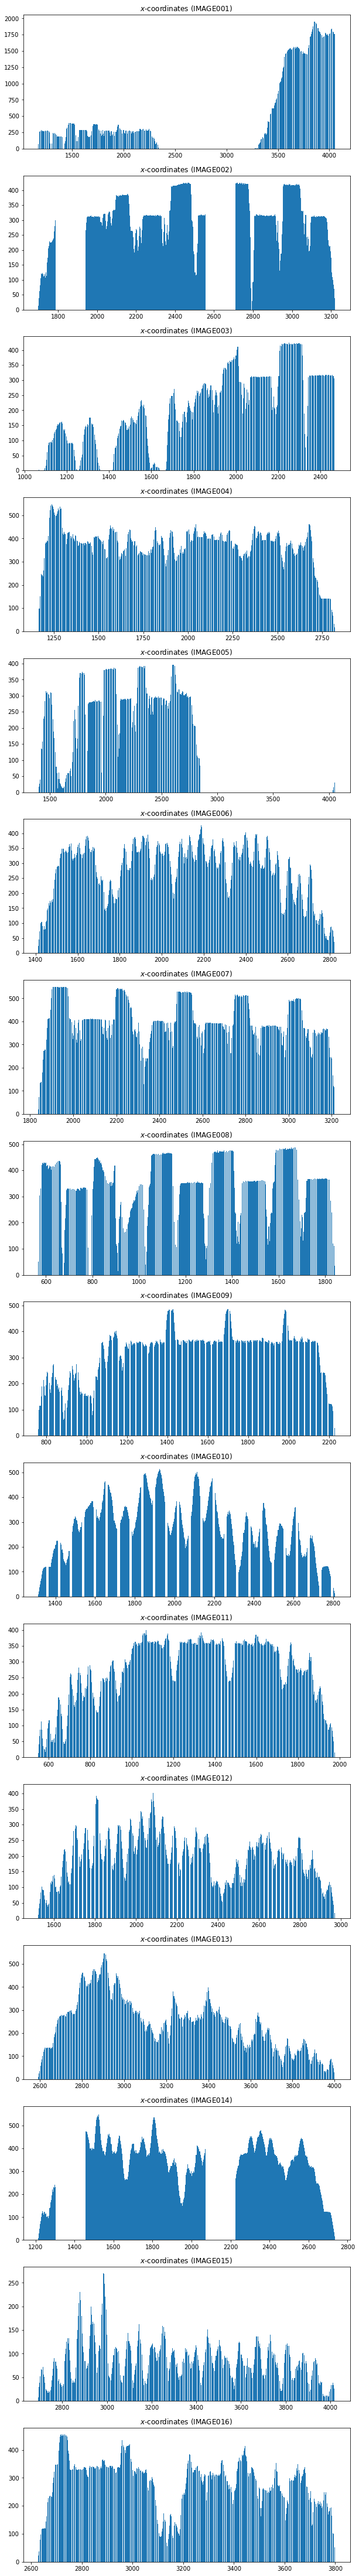

In [5]:
fig, axes = plt.subplots(n, 1, figsize=(figsize[0], figsize[1]*n))
for index in range(n):
    indeces, height = np.unique(
        np.array([location[0] for location in darkpixel_dict[f"IMAGE{index+1:03}"]]),
        return_counts=True
    )
    axes[index].bar(indeces, height)
    axes[index].set_title(f"$x$-coordinates (IMAGE{index+1:03})")

Looks like we have some separation in the $x$-coordinates. We can easily calculate the change in the $x$-coordinates, $\Delta x$. 

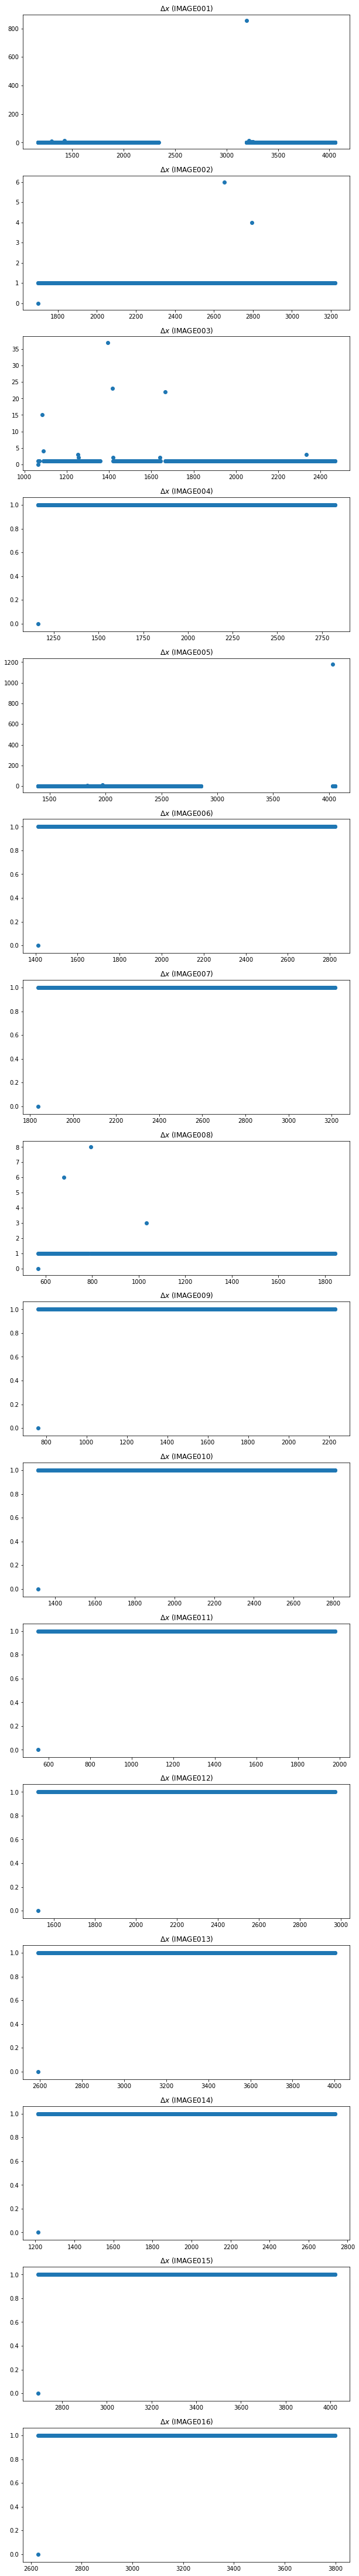

In [6]:
fig, axes = plt.subplots(n, 1, figsize=(figsize[0], figsize[1]*n))
for index in range(n):
    indeces, height = np.unique(
        np.array([location[0] for location in darkpixel_dict[f"IMAGE{index+1:03}"]]),
        return_counts=True
    )
    delta_index = np.array([0]+[indeces[x] - indeces[x-1] for x in range(1, indeces.shape[0])])
    axes[index].scatter(indeces, delta_index)
    axes[index].set_title(f"$\Delta x$ (IMAGE{index+1:03})")

After looking at the graphs, we can see that the images with false positives have $\Delta x$ values over 50. 

Let's say if there is a $\Delta x$ that exceeds 50 pixels, there is a significant gap. From here we will separate the groups of dark pixels by separating the groups of pixels by the large $\Delta x$ value. Now we chose which group of pixels has the lower standard deviation and is at least 100 pixels wide.

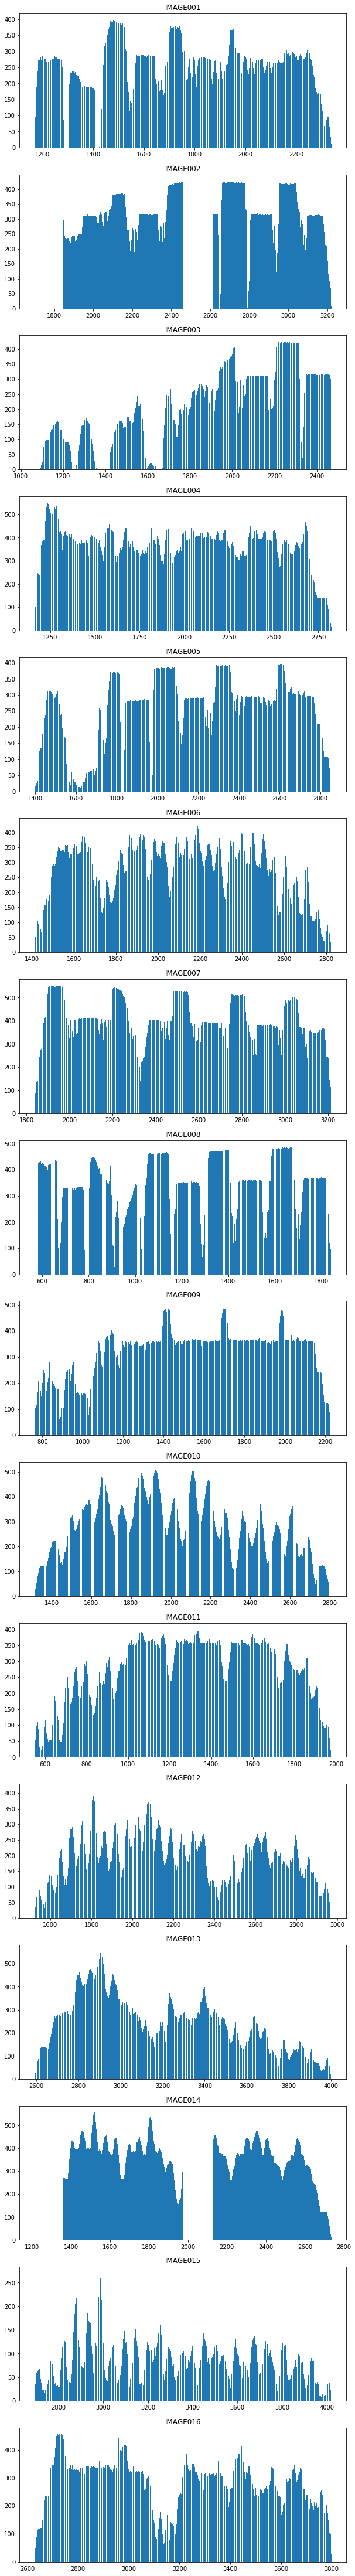

In [7]:
fig, axes = plt.subplots(n, 1, figsize=(figsize[0], figsize[1]*n))
for index in range(n):
    indeces, height = np.unique(
        np.array([location[0] for location in darkpixel_dict[f"IMAGE{index+1:03}"]]),
        return_counts=True
    )
    delta_index = np.array([0]+[indeces[x] - indeces[x-1] for x in range(1, indeces.shape[0])])
    # Check for the high delta-x
    if delta_index.max() > 50:
        completed = False
        if delta_index[:np.where(delta_index == delta_index.max())[0][0]].std() < 5 and \
            height[:np.where(delta_index == delta_index.max())[0][0]].shape[0] > 100 and \
            not completed:
            darkpixel_dict[f"IMAGE{index+1:03}"] = [
                pixel 
                for pixel in darkpixel_dict[f"IMAGE{index+1:03}"] 
                if pixel[0] < indeces[np.where(delta_index == delta_index.max())[0][0]]
            ]
            indeces, height = np.unique(
                np.array([location[0] for location in darkpixel_dict[f"IMAGE{index+1:03}"]]),
                return_counts=True
            )
            completed = True
        if delta_index[np.where(delta_index == delta_index.max())[0][0]:].std() < 5 and \
            height[np.where(delta_index == delta_index.max())[0][0]:].shape[0] > 100 and \
            not completed:
            darkpixel_dict[f"IMAGE{index+1:03}"] = [
                pixel 
                for pixel in darkpixel_dict[f"IMAGE{index+1:03}"] 
                if pixel[0] > indeces[np.where(delta_index == delta_index.max())[0][0]]
            ]
            indeces, height = np.unique(
                np.array([location[0] for location in darkpixel_dict[f"IMAGE{index+1:03}"]]),
                return_counts=True
            )
            completed = True
        if not completed:
            raise ValueError("Couldn't determine which cluster of pixels has checkboard!")
    axes[index].bar(indeces, height)
    axes[index].set_title(f"IMAGE{index+1:03}")
plt.show()

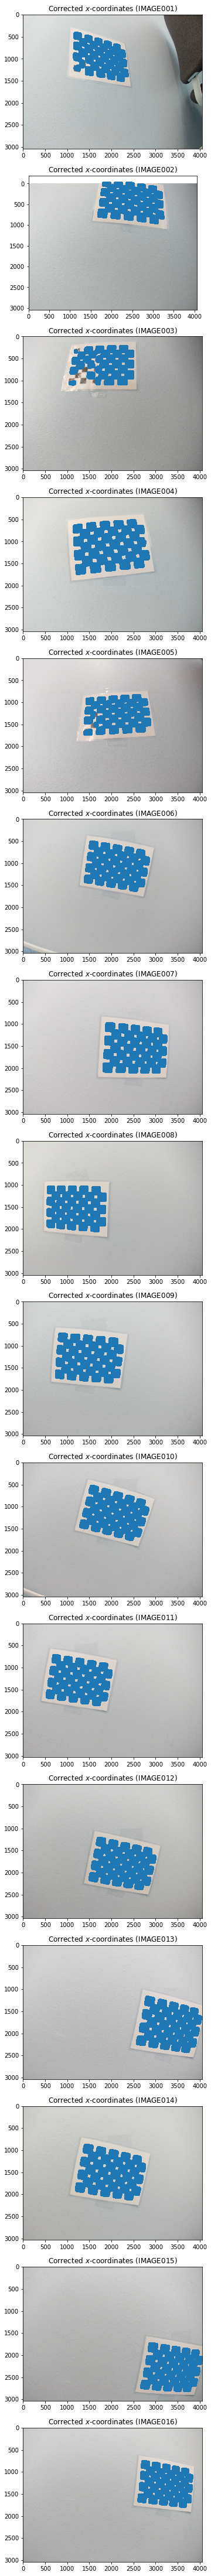

In [8]:
fig, axes = plt.subplots(n, 1, figsize=(figsize[0], figsize[1]*n))
for index in range(n):
    axes[index].imshow(calibration_images[index])
    axes[index].scatter(
        [x[0] for x in darkpixel_dict[f"IMAGE{index+1:03}"]], 
        [x[1] for x in darkpixel_dict[f"IMAGE{index+1:03}"]]
    )
    axes[index].set_title(f"Corrected $x$-coordinates (IMAGE{index+1:03})")
plt.show()

We have successfully found the checkerboards in all of the images!

## Finding the Innermost Corners

We've currently found all the black squares of the checkerboards in the $n$ images. Now, we must find the intersecting corners of the individual black squares. To make this process easier, let's select the best images. Let's say the best images:
- do not reflect light
- have all of the black squares in the checkerboard selected
- have the entire checkerboard in frame

The checkerboard pattern is 5 by 4 black squares. Luckily, we can use OpenCV's `findChessboardCorners()` function. This function uses the parameters:
- the image of the checkerboard
- the number of inner corners (9, 6)

Before explicitly calling the function, let's look at whether we can effectively find the intersecting corners.

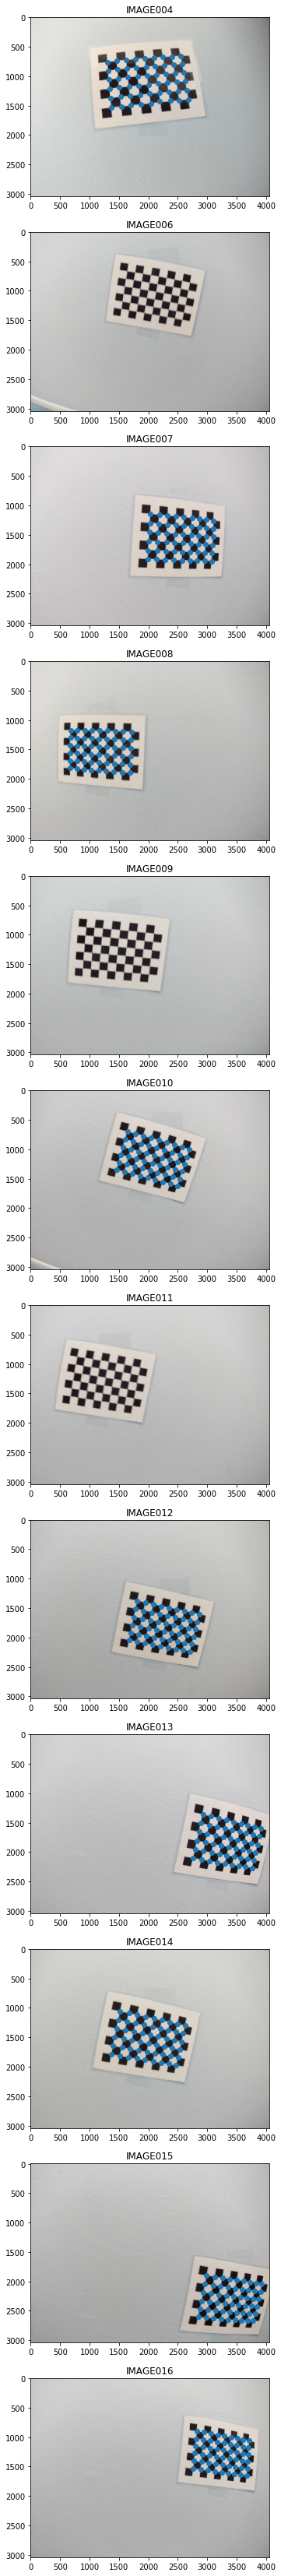

[3, 6, 7, 9, 11, 12, 13, 14, 15]


In [13]:
n_select = [3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
n_found = []
fig, axes = plt.subplots(len(n_select), 1, figsize=(figsize[0], figsize[1]*len(n_select)))
for n_select_index in range(len(n_select)):
    index = n_select[n_select_index]
    x = np.array([point[0] for point in darkpixel_dict[f"IMAGE{index+1:03}"]])
    y = np.array([point[1] for point in darkpixel_dict[f"IMAGE{index+1:03}"]])
    gray_img = cv2.cvtColor(
        calibration_images[index][y.min():y.max(), x.min():x.max(), :], 
        cv2.COLOR_BGR2GRAY
    )
    axes[n_select_index].imshow(calibration_images[index])
    found, features = cv2.findChessboardCorners(gray_img, (9, 6))
    if found:
        n_found.append(index)
        features = np.array([[[feature[0][0]+x.min(),feature[0][1]+y.min()]] for feature in features])
        axes[n_select_index].scatter([point[0][0] for point in features], [point[0][1] for point in features])
    axes[n_select_index].set_title(f"IMAGE{index+1:03}")
plt.show()
print(n_found)

So, we see that the `findChessboardCorners()` function could not "find chessboard corners" for some of the images. Let's use all of the images with found chessboards to calibrate the camera. OpenCV has a really good [tutorial](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html) for calibrating cameras. The following code is taken from there. 

In [14]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

for n_select_index in range(len(n_found)):
    index = n_found[n_select_index]
    x = np.array([point[0] for point in darkpixel_dict[f"IMAGE{index+1:03}"]])
    y = np.array([point[1] for point in darkpixel_dict[f"IMAGE{index+1:03}"]])
    gray_img = cv2.cvtColor(
        calibration_images[index][y.min():y.max(), x.min():x.max(), :], 
        cv2.COLOR_BGR2GRAY
    )
    axes[n_select_index].imshow(calibration_images[index])
    axes[n_select_index].set_title(f"IMAGE{index+1:03}")
    found, features = cv2.findChessboardCorners(gray_img, (9, 6))
    if found:
        features = np.array([[[feature[0][0]+x.min(),feature[0][1]+y.min()]] for feature in features])
        features2 = cv2.cornerSubPix(
            cv2.cvtColor(calibration_images[index], cv2.COLOR_BGR2GRAY), 
            np.float32(features), 
            (11,11), 
            (-1,-1), 
            criteria
        )
        objpoints.append(objp)
        imgpoints.append(features2)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray_img.shape[::-1], None, None)
print(mtx)

[[4.23209107e+03 0.00000000e+00 1.64499265e+03]
 [0.00000000e+00 4.18672376e+03 1.45619792e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


We have calculated the calibration matrix, $K$, of a given camera system.

## Undistortion

We can use this calibration matrix to undistort the images taken by this camera system. Again, we can use the [tutorial](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html) provided by OpenCV. The first portion of the tutorial deals with producing the calibration matrix with respect to the size of the images produced by the camera.

In [15]:
n_image = 3
height, width = calibration_images[0].shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(
    mtx, dist, (width, height), 1, (width, height)
)

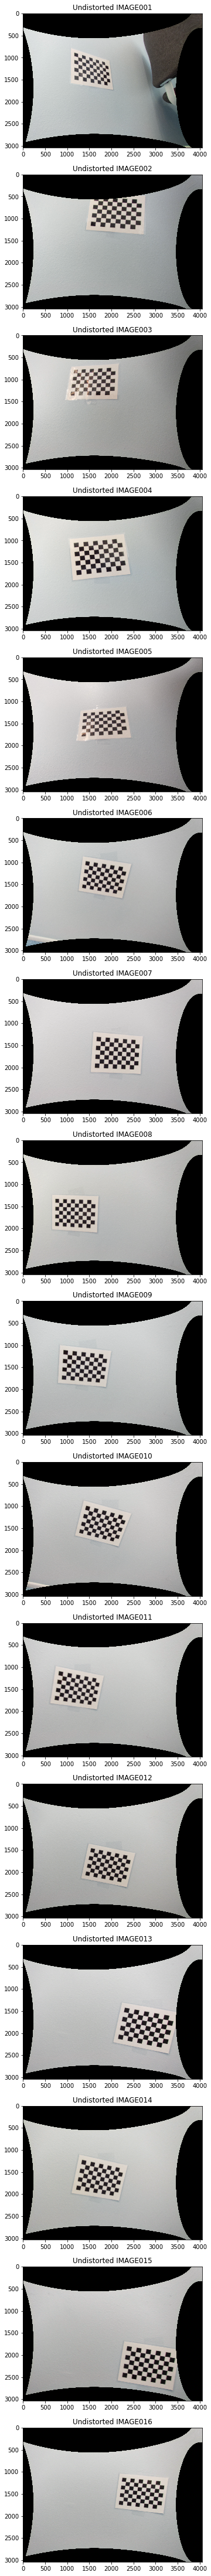

In [16]:
fig, axes = plt.subplots(n, 1, figsize=(figsize[0], figsize[1]*n))
for index in range(n):
    axes[index].imshow(
        cv2.undistort(calibration_images[index], mtx, dist, None, newcameramtx)
    )
    axes[index].set_title(f"Undistorted IMAGE{index+1:03}")

Now, we can see how this checkerboard pattern can help us determine which surfaces are flat. This "homography," helps us *easily* calibrate camera systems. Now, we can use this calibration to determine geometry in the real-world.